# ConvLSTM Implementation
The overall flow is similar to MLP implementation, hyperparameters & model structure are the main differences.


In [1]:
import torch
from torch import nn
import numpy as np
import pandas as pd
from d2l import torch as d2l

## Self-defined ConvLSTM Layer
description to be added

parameter initialization is done here

reference: https://github.com/automan000/Convolutional_LSTM_PyTorch/blob/master/convolution_lstm.py#L15

In [2]:
#Original ConvLSTM Paper with extra terms
class ConvLSTMCell(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size):
        super().__init__()
        assert hidden_channels % 2 == 0
        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
        self.num_features = 3#check this one
        self.padding = (kernel_size - 1)//2
        
        self.Wxi = nn.Conv1d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias = True)
        self.Whi = nn.Conv1d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias = False)
        self.Wxf = nn.Conv1d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias = True)
        self.Whf = nn.Conv1d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias = False)
        self.Wxc = nn.Conv1d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias = True)
        self.Whc = nn.Conv1d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias = False)
        self.Wxo = nn.Conv1d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias = True)
        self.Who = nn.Conv1d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias = False)
        self.Wci = None
        self.Wcf = None
        self.Wco = None
        #parameter initialization
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                m.weight = nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    m.bias = nn.init.zeros_(m.bias)
    def forward(self, x, h, c):
        i_t = torch.sigmoid(self.Wxi(x) + self.Whi(h) + c*self.Wci)
        f_t = torch.sigmoid(self.Wxf(x) + self.Whf(h) + c*self.Wcf)
        c_t = f_t*c + i_t*torch.tanh(self.Wxc(x) + self.Whc(h))
        o_t = torch.sigmoid(self.Wxo(x) + self.Who(h) + c_t*self.Wco)
        h_t = o_t*torch.tanh(c_t)
        return h_t, c_t
    def init_hidden(self, batch_size, hidden, size):
        self.Wci = nn.Parameter(torch.zeros(1, hidden, size))
        self.Wcf = nn.Parameter(torch.zeros(1, hidden, size))
        self.Wco = nn.Parameter(torch.zeros(1, hidden, size))
        return (torch.zeros(batch_size, hidden, size), torch.zeros(batch_size, hidden, size))
        
class ConvLSTM(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size, step = 1, effective_step = [1]):
        super().__init__()
        self.channels = [input_channels] + hidden_channels
        self.kernel_size = kernel_size
        self.num_layers = len(hidden_channels)
        self.step = step
        self.effective_step = effective_step
        self._all_layers = []
        for i in range(self.num_layers):
            name = "cell{}".format(i)
            cell = ConvLSTMCell(self.channels[i], self.channels[i+1], self.kernel_size)
            setattr(self, name, cell)
            self._all_layers.append(cell)
    def forward(self, input):
        internal_state = []
        outputs = []
        for step in range(self.step):
            x = input
            for i in range(self.num_layers):
                name = "cell{}".format(i)
                if step == 0:
                    bsize,_,size = x.size()
                    h,c = getattr(self, name).init_hidden(batch_size = bsize, hidden = self.channels[i+1], size = size)
                    internal_state.append((h,c))
                h,c = internal_state[i]
                x, new_c = getattr(self, name)(x, h, c)
                internal_state[i] = x, new_c
            if step in self.effective_step:
                outputs.append(x)
        return x#outputs, (x, new_c)

## Hyperparameters
using less epochs (30) compared to MLP (100) due to slower computation of ConvLSTM

using longer lag period (40 compared to 20) (I saw a guide stating that it's a good practice to have no. of channels in decreasing order)

In [3]:
#Config Parameters
quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.60, 0.70, 0.80, 0.90, 0.95]
qlen = len(quantiles)
i_train = 2400
i_val = i_train + 800
i_test = i_val + 1600 

batch_size, lr, n_epochs, num_iter = 128, 0.001, 30, 30
lag_period, num_features, forecast_horizon = 40, 14, 2
num_inputs, num_outputs, num_hidden = lag_period, 1+qlen, 30
# dropout= 0.2
kernel_size = 3

## Load & Split Data
same as MLP

In [4]:
#Load & Split Data
data = pd.read_csv("/Users/lixiang/Desktop/DeepJMQR Project/data.csv")
alldata = np.array(data)[:,1:].astype("float32")
torch.set_default_dtype(torch.float32)
X = []
for i in range(lag_period, len(data)):
    X.append(alldata[i-lag_period:i])
X = torch.tensor(np.array(X))
Y = alldata[lag_period+forecast_horizon:]

X_train, Y_train = X[:i_train], torch.tensor(Y[:i_train])
X_val, Y_val = X[i_train:i_val], Y[i_train:i_val]
X_test, Y_test = X[i_val:i_test], Y[i_val:i_test]
train_iter = torch.utils.data.DataLoader(list(zip(X_train,Y_train)), batch_size=batch_size, shuffle = True)
val_iter = torch.utils.data.DataLoader(list(zip(X_val,Y_val)), batch_size=batch_size, shuffle = False)

## Evaluation & Loss Functions (per sample)
same as MLP, made some changes there so that the functions work here

In [5]:
#Evaluation & Loss Functions
def lossfn(τ, y, ŷ):
    loss = torch.sum(torch.square(y-ŷ[:,0,:]))
    for i in range(len(τ)):
        q = τ[i]
        r = y - ŷ[:,i+1,:]
        loss += torch.sum(q*r - r*(r<0))
    loss /= y.shape[0]
    return loss

#for evaluation: remember to turn tensors into np.array()
def tilted_loss(τ, y, ŷ):
    loss = 0.0
    for i in range(len(τ)):
        q = τ[i]
        r = y - ŷ[:,i+1,:]
        loss += np.sum(q*r - r*(r<0))
    loss /= y.shape[0]
    return loss

def crossing_loss(ŷ):
    loss = 0.0 #crossing loss as defined in the paper
    num_cross = 0.0
    for i in range(len(ŷ[0,:,0])-2):
        q = ŷ[:,i+1,:] - ŷ[:,i+2,:]
        loss += np.sum(np.maximum(q,0))
        num_cross += np.sum(q>0)
    loss /= ŷ.shape[0]
    num_cross /= ŷ.shape[0]
    return loss, num_cross

def eval_quantiles(lower, upper, y):
    icp = np.mean((y > lower) & (y < upper))
    mil = np.mean(np.maximum(0,upper-lower))
    return icp,mil

def eval_error(y, ŷ):
    #y, ŷ: np.array() of same shape as defined in lossfn
    r = np.abs(y-ŷ[:,0,:])
    mse = np.mean(r*r)
    rmse = np.sqrt(mse)
    mae = np.mean(r)
    return mse, rmse, mae

## Model Initialization
on top of ConvLSTM, there's a final output layer which, according to DeepJMQR's author, is equivalent to a 1x1 linear convolutional layer

initialize the output layer parameters here

to do: try adding more/different layers (yet to try every possibilities)
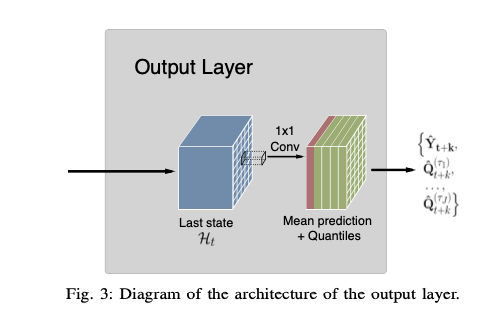

In [6]:
def init_module(m):
    nn.init.normal_(m.weight, std=0.01)
    nn.init.zeros_(m.bias)
#Initialize Model
def init():
    net = nn.Sequential(ConvLSTM(num_inputs, [num_hidden], kernel_size,step=1,effective_step=[1]),
                        nn.Conv1d(num_hidden,num_outputs,1, bias = True))
    net[1].apply(init_module)
    return net

## Training, Iteration & Validation
same as MLP

In [7]:
#Train Model
def train(model, train_iter, quantiles, loss_fn, optimizer, num_epochs = 100):
    running_loss = 0
    last_loss = 0
    for i, data in enumerate(train_iter):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(quantiles, labels, outputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        last_loss = loss.item()
    return last_loss

def iter():
#     animator = d2l.Animator(xlabel = "epoch", ylabel = "loss", xlim = [1,n_epochs], ylim = [0,1], legend = ["train", "val"])
    best_vloss = 1e9
    for epoch in range(n_epochs):
        net.train(True)
        avg_loss = train(net, train_iter, quantiles, lossfn, optimizer, num_epochs = n_epochs)
        net.train(False)
        running_vloss = 0.0
        for i, vdata in enumerate(val_iter):
            vinputs, vlabels = vdata
            voutputs =  net(vinputs)
            vloss = lossfn(quantiles, vlabels, voutputs)
            running_vloss += vloss
        avg_vloss = float(running_vloss / (i+1))
#         if epoch % (n_epochs/20) == 0:
#         animator.add(epoch+1, (avg_loss, avg_vloss))
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            torch.save(net, "model_best_state_ConvLSTM")
    model = torch.load("model_best_state_ConvLSTM")
    pred = model(X_val).detach().numpy()
    return pred

## Reiterate & Evaluate Errors
same as MLP

In [8]:
#Iterate 
cl,tl,err,icp,mil = [],[],[],[[] for _ in range(qlen//2)],[[] for _ in range(qlen//2)]
for k in range(num_iter):
    net = init()
    optimizer = torch.optim.Adam(net.parameters(), lr = lr)
    pred = iter()
    cl.append(crossing_loss(pred))
    tl.append(tilted_loss(quantiles,Y_val,pred))
    err.append(eval_error(Y_val,pred))
    print("... finished running iter",k+1)
    for i in range(qlen//2):
        t1,t2 = eval_quantiles(pred[:,i+1,:],pred[:,qlen-i,:],Y_val)
        icp[i].append(t1)
        mil[i].append(t2)

... finished running iter 1
... finished running iter 2
... finished running iter 3
... finished running iter 4
... finished running iter 5
... finished running iter 6
... finished running iter 7
... finished running iter 8
... finished running iter 9
... finished running iter 10
... finished running iter 11
... finished running iter 12
... finished running iter 13
... finished running iter 14
... finished running iter 15
... finished running iter 16
... finished running iter 17
... finished running iter 18
... finished running iter 19
... finished running iter 20
... finished running iter 21
... finished running iter 22
... finished running iter 23
... finished running iter 24
... finished running iter 25
... finished running iter 26
... finished running iter 27
... finished running iter 28
... finished running iter 29
... finished running iter 30


## Print Mean of Errors

In [9]:
#Evaluate Errors
def print_error(cl, tl, err, icp, mil):
    print("Crossing Loss:", np.mean([y[0] for y in cl]), ", Number of Crosses:", np.mean([y[1] for y in cl]))
    print("MSE:",np.mean([y[0] for y in err]), "RMSE:", np.mean([y[1] for y in err]),"MAE:", np.mean([y[2] for y in err]))
    print("Tilted loss:", np.mean(tl))
    print("Prediction Intervals:")
    for i in range(qlen//2):
        print(round((quantiles[qlen-i-1]-quantiles[i])*100),"% ICP & MIL:",round(np.mean(icp[i]),6),round(np.mean(mil[i]),6))

In [10]:
print_error(cl, tl, err, icp, mil)

Crossing Loss: 0.0001071317368441669 , Number of Crosses: 0.44195833333333334
MSE: 4.5218203e-05 RMSE: 0.0067244144 MAE: 0.0037907925
Tilted loss: 0.20420269016424814
Prediction Intervals:
90 % ICP & MIL: 0.93947 0.025486
80 % ICP & MIL: 0.85094 0.014391
60 % ICP & MIL: 0.621988 0.005865
40 % ICP & MIL: 0.396604 0.002436
20 % ICP & MIL: 0.190997 0.000834


## Some Observations
MLP Errors (per sample) for Comparison:<br>
Crossing Loss: 0.016875776926385398 , Number of Crosses: 18.678<br>
MSE: 4.5187422e-05 RMSE: 0.0067216274 MAE: 0.0038696693<br>
Tilted loss: 0.186080036620299<br>
Prediction Intervals:<br>
90 % ICP & MIL: 0.907583 0.018095<br>
80 % ICP & MIL: 0.796179 0.012799<br>
60 % ICP & MIL: 0.586277 0.00775<br>
40 % ICP & MIL: 0.399134 0.004641<br>
20 % ICP & MIL: 0.20622 0.002238<br>

1. ConvLSTM causes slightly higher tilted loss but significantly lowers crossing loss which aligns with the author's claim on page 10 <br>
"there is a trade-off in place between the quantity of the quantiles (according to the tilted loss) and addressing the quantile crossings problem (crossing loss) by constraining the flexibility of the quantile functions via multi-task learning"<br>
2. similar error values (RMSE & MAE): still higher than errors from the dummy prediction<br>
3. similar performance in prediction intervals (none of which clearly dominates the other)

## Dummy Prediction

In [11]:
#Dummy Prediction for Comparison
cl,tl,err,icp,mil = [],[],[],[[] for _ in range(qlen//2)],[[] for _ in range(qlen//2)]
p = np.array([[[0 for _ in range(pred.shape[2])] for _ in range(pred.shape[1])] for _ in range(pred.shape[0])])
cl.append(crossing_loss(p))
tl.append(tilted_loss(quantiles,Y_val,p))
err.append(eval_error(Y_val,p))
for i in range(qlen//2):
    t1,t2 = eval_quantiles(p[:,i+1,:],p[:,qlen-i],Y_val)
    icp[i].append(t1)
    mil[i].append(t2)

In [12]:
print_error(cl, tl, err, icp, mil)

Crossing Loss: 0.0 , Number of Crosses: 0.0
MSE: 4.4329104918412386e-05 RMSE: 0.006658010582629948 MAE: 0.0037047623680851135
Tilted loss: 0.259333365765958
Prediction Intervals:
90 % ICP & MIL: 0.0 0.0
80 % ICP & MIL: 0.0 0.0
60 % ICP & MIL: 0.0 0.0
40 % ICP & MIL: 0.0 0.0
20 % ICP & MIL: 0.0 0.0


### Some experiments
I believe that getting the signs correctly is probably the most important thing when predicting returns but the model seems to only get around half of the signs correctly (in the cell below), which doesn't seem to be better than MLP

In [13]:
np.mean(pred[:,0,:]*Y_val>0)

0.4976785714285714

In [14]:
print(np.mean(pred[:,:,0]>0))
print(np.mean(Y_val[:,:]>0))

0.5415909090909091
0.5157142857142857
